## VAP(Volume at Price)を計算しグラフ化する。

In [167]:
import os
import datetime
import pandas as pd
from urllib import request

def get_bb_log(yyyy, mm, dd, symbol="BTCUSD"):
    """
    bybitからパラメーターに指定された日付の約定データを/tmpにダウンロードする。
    /tmpに一時保存することでキャッシュ機能を実現
    :param yyyy: 年（４桁）
    :param mm: 月
    :param dd: 日
    :param symbol: オプション：ディフォルトBTCUSD
    :return: /tmpにダウンロードしたファイル名
    """
    file_name = f'{symbol}{yyyy:04d}-{mm:02d}-{dd:02d}.csv.gz'
    tmp_file = '/tmp/'+ file_name

    if not os.path.exists(tmp_file):
        download_url = f'https://public.bybit.com/trading/{symbol}/{file_name}'
        print("download url=", download_url)
        request.urlretrieve(download_url, tmp_file)

    return tmp_file

def get_bb_df(yyyy, mm, dd):
    """
    bybitから約定データをダウンロードしpandasのDataFrameオブジェクトにする。
    :param yyyy: 年（４桁）
    :param mm: 月
    :param dd: 日
    :return: 約定データが入ったDataFrame
    """
    file = get_bb_log(yyyy, mm, dd)

    bb_df = pd.read_csv(file, index_col=0)
    bb_df.index = pd.to_datetime(bb_df.index, utc=True, unit='s')

    return bb_df


def resample_ohlcv(data, sample_time):
    """
    約定データからohlcvを作成する。
    timeに指定できるパラメータは文字列で以下のように指定する。
    15秒:'15S' / 1分: '1T' / 1時間: '1H'
    詳細はpadnasのドキュメント
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    :param data:　bybitの約定データの入ったDataFrame
    :param sample_time: サンプル間隔
    :return: ohlcvデータ
    """
    resample_df = data['price'].resample(sample_time).ohlc()
    resample_df['volume'] = data['size'].resample(sample_time).sum()
    return resample_df

def get_bb_df_past_days(days=10, start_day = None):
    """
    Bybitから過去から指定期間のデータをダウンロードしdfを返す。
    データが生成できていない可能性があるので２日前までの期間のデータをダウンロードする。
    :param days: データ取得期間
    :param start_day: 開始時間（指定しない場合は今日からdays+2日前）
    :return: 約定データが入ったdf
    """
    if not start_day:
        start_day = datetime.date.today() - datetime.timedelta(days=days+2)

    print('start:', start_day, "-> end:", start_day + datetime.timedelta(days=days))

    bb_df = None
    for i in range(days):
        target_day = start_day + datetime.timedelta(days=i)
        download_df = get_bb_df(target_day.year, target_day.month, target_day.day)
        if bb_df is None:
            bb_df = download_df
        else:
            bb_df = bb_df.append(download_df)

    return bb_df

In [168]:
# 過去データの取得
df = get_bb_df_past_days(1)


start: 2021-10-01 -> end: 2021-10-02
download url= https://public.bybit.com/trading/BTCUSD/BTCUSD2021-10-01.csv.gz


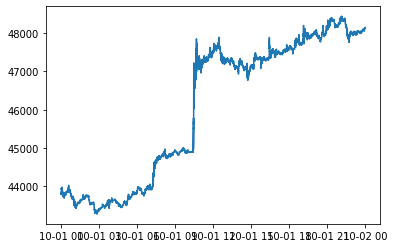

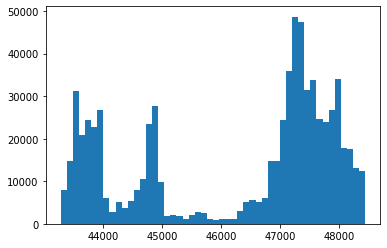

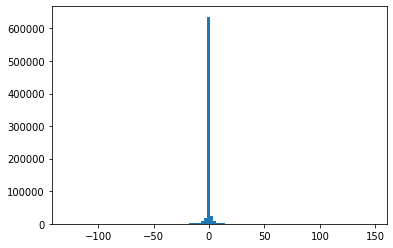

In [169]:
import matplotlib.pyplot as plt
price = df['price']
plt.plot(price)
plt.show()

plt.hist(price, bins=50)
plt.show()

price_diff = price.diff().dropna()
plt.hist(price_diff, bins=100)
plt.show()

In [170]:
import numpy as np
from sklearn.linear_model import LinearRegression

def make_list(x):
    g = x.groupby(['side', 'price'])['homeNotional'].sum()
    return g


In [171]:
chunk = df[0:100]

print(chunk.index[len(chunk)-1])
print(chunk.index[0])

print(chunk.iloc[0]['price'])



2021-10-01 23:59:38.311000064+00:00
2021-10-01 23:59:59.305999872+00:00
48131.5


In [198]:
def calc_hist(x, prob_mode=False):
    last_index = len(x) - 1

    edge0 = x.index[0]
    edge1 = x.index[last_index]

    print('edge0', edge0)
    print('edge1', edge1)

    if edge0 < edge1:
        start_time = edge0
        start_price = x.iloc[0]['price']
        print('start->', start_price)
    else:
        start_time = edge1
        start_price = x.iloc[last_index]['price']
        print('start->', start_price)


    if prob_mode:
        total = x['homeNotional'].sum()
        r = x.groupby(['side', 'price'])['homeNotional'].sum()/total
    else:
        r = x.groupby(['side', 'price'])['homeNotional'].sum()

    return start_price, r

def pd_to_list(h, start, list_size):
    l = []
    plist = []

    times = h.index.values.tolist()

    for i in range(-list_size, list_size+1):
        p = start+i/2
        plist += [p]

        if p in times:
            l += [h[p]]
        else:
            l += [0]

    return l, plist

def make_hist_list(x, list_size=100, prob_mode = False):
    start_price, r = calc_hist(x, prob_mode)

    buy_list, plist = pd_to_list(r.xs('Buy', level='side'), start_price, list_size)
    sell_list, plist = pd_to_list(r.xs('Sell', level='side'), start_price, list_size)

    return start_price, buy_list, sell_list, plist

edge0 2021-10-01 23:03:57.855000064+00:00
edge1 2021-10-01 22:59:59.569999872+00:00
start-> 47982.5


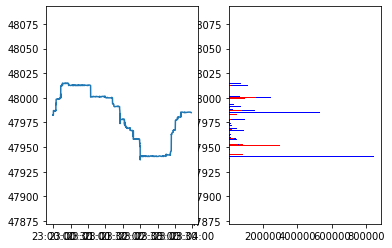

In [199]:
sample = df[8000: 9000]

s, l1, l2, plist = make_hist_list(sample, 200)

fig = plt.figure()

sp2 = fig.add_subplot(1, 2, 2)
sp2.barh(plist, l1, color='Red')
sp2.barh(plist, l2, color='Blue', left=l1)
ymin, ymax = plt.ylim()

sp1 = fig.add_subplot(1, 2, 1)
sp1.plot(sample['price'])
plt.ylim(ymin, ymax)


plt.show()

In [231]:
def make_array(s, start_price, list_size=100):
    array = []

    times = s.index.values.tolist()

    for i in range(-list_size, list_size+1):
        p = start_price+i/2

        if p in times:
            array += [s[p]]
        else:
            array += [0]

    return array




def show(x):
    start_price = x['price'].iloc[0]
    total = x['homeNotional'].sum()
    r = x.groupby(['side', 'price'])['homeNotional'].sum()/total

    buy = r.xs('Sell', level='side')
    sell = r.xs('Sell', level='side')

    buy_array = make_array(buy, start_price)
    sell_array = make_array(sell, start_price)

    return start_price, buy_array, sell_array


resample = df.resample('1T')

print(resample.apply(show))




timestamp
2021-10-01 00:00:00+00:00    (43800.0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2021-10-01 00:01:00+00:00    (43800.0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2021-10-01 00:02:00+00:00    (43845.5, [8.446201329398305e-08, 4.0034994301...
2021-10-01 00:03:00+00:00    (43948.5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2021-10-01 00:04:00+00:00    (43957.0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                                                   ...                        
2021-10-01 23:55:00+00:00    (48076.0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2021-10-01 23:56:00+00:00    (48059.5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2021-10-01 23:57:00+00:00    (48086.5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2021-10-01 23:58:00+00:00    (48117.5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2021-10-01 23:59:00+00:00    (48118.0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Freq: T, Length: 1440, dtype: object


In [190]:
d = data.loc[time_group[2], :]

print(d)
print(d.index)



timestamp                  side  price  
2021-10-01 00:01:00+00:00  Buy   43800.0    83607
                                 43800.5       48
                                 43801.0     6618
                                 43801.5     1224
                                 43802.0     1117
                                            ...  
                           Sell  43822.0        4
                                 43823.0        3
                                 43825.5       23
                                 43828.5       12
                                 43841.5     5644
Name: homeNotional, Length: 88, dtype: int64
MultiIndex([('2021-10-01 00:01:00+00:00',  'Buy', 43800.0),
            ('2021-10-01 00:01:00+00:00',  'Buy', 43800.5),
            ('2021-10-01 00:01:00+00:00',  'Buy', 43801.0),
            ('2021-10-01 00:01:00+00:00',  'Buy', 43801.5),
            ('2021-10-01 00:01:00+00:00',  'Buy', 43802.0),
            ('2021-10-01 00:01:00+00:00',  'Buy', 43803.0),
    

In [ ]:
make_hist_list(data.loc[time_group[2], :])

In [ ]:

data_buy= data.xs("Buy", level='side')
data_sell= data.xs("Sell", level='side')

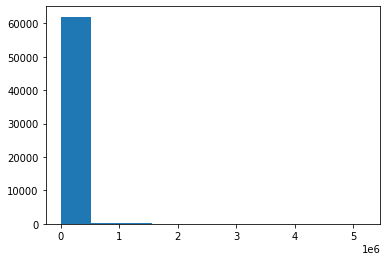

In [41]:
plt.hist(data_buy)
plt.show()